In [1]:
import sys
sys.path.append('/home/onyxia/work/libsigma')
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import classification as cla
import plots

# Définir les paramètres
shp_path = '../results/data/sample/Sample_BD_foret_T31TCJ.shp'  # Chemin vers le shapefile
raster_path = '../results/data/img_pretraitees/Serie_temp_S2_allbands.tif'  # Chemin vers l'image raster
raster_temp_code_pixel = '../results/data/classif/raster_code_pixel.tif'  # Raster avec Code_pixel comme valeur
raster_temp_ids = '../results/data/classif/raster_ids.tif'  # Raster avec des IDs uniques
field_name_cp = 'Code_pixel'  
spatial_resolution = 10  # Résolution spatiale du raster (en mètres)
is_point = False

In [2]:
# Création d'un champ 'ID' valide
gdf = gpd.read_file(shp_path)
gdf['ID_Good'] = range(1, len(gdf) + 1)

# Sauvegarder le shapefile avec le nouveau champ
shp_output = '../results/data/sample/Sample_BD_foret_T31TCJ_with_ID.shp'
gdf.to_file(shp_output)
field_name_ids = 'ID_Good'

In [ ]:
# Coordonnées de la bounding box (xmin, ymin, xmax, ymax)
xmin = 501135.41
ymin = 6240660.64
xmax = 609755.41
ymax = 6314460.64

# Rasterisation
gdal_cmds = [
    f"gdal_rasterize -a {field_name_cp} -tr {spatial_resolution} {spatial_resolution} -te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff {shp_path} {raster_temp_code_pixel}",
    f"gdal_rasterize -a {field_name_ids} -tr {spatial_resolution} {spatial_resolution} -te {xmin} {ymin} {xmax} {ymax} -ot Int32 -of GTiff {shp_output} {raster_temp_ids}"
]

for cmd in gdal_cmds:
    os.system(cmd)

ds = gdal.Open(raster_temp_ids)
if ds is None:
    print("Erreur : raster_temp_ids est introuvable ou corrompu.")
else:
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Valeurs uniques dans raster_temp_ids : [    0     1     2 ... 10980 10981 10982]


In [4]:
# Extraction des échantillons
if not is_point:
    X, Y, t = cla.get_samples_from_roi(raster_path, raster_temp_code_pixel)
    _, groups, _ = cla.get_samples_from_roi(raster_path, raster_temp_ids)
else:
    # Extraire X
    list_row, list_col = rw.get_row_col_from_file(raster_temp_code_pixel, raster_path)
    image = rw.load_img_as_array(raster_path)
    X = image[(list_row, list_col)]

    # Extraire Y
    gdf = gpd.read_file(raster_temp_code_pixel)
    Y = gdf.loc[:, field_name_cp].values
    Y = np.atleast_2d(Y).T

In [8]:
# Aplatir les groupes en un tableau unidimensionnel
groups = np.squeeze(groups)

# S'assurer que 'groups' a la même forme que X et Y
if groups.shape != X.shape:
    print(f"Dimensions incompatibles : X shape = {X.shape}, groups shape = {groups.shape}")
    # Ajustement de la taille de 'groups' pour correspondre à X
    groups_resampled = np.resize(groups, X.shape)
    groups = groups_resampled  # Mettez à jour 'groups' si nécessaire
else:
    print("Les dimensions de X et groups sont compatibles.")

# Vérification que tous les échantillons sont synchronisés
print(f"Nombre d'échantillons de X: {X.shape[0]}")
print(f"Nombre d'échantillons de Y: {Y.shape[0]}")
print(f"Nombre d'échantillons de groups: {groups.shape[0]}")

Les dimensions de X et groups sont compatibles.
Nombre d'échantillons de X: 2468213
Nombre d'échantillons de Y: 2468213
Nombre d'échantillons de groups: 2468213


In [9]:
# Initialisation de la validation croisée
nb_iter = 1
nb_folds = 2
list_cm = []
list_accuracy = []
list_report = []

# Initialisation du classifieur RandomForest
rf_classifier = RandomForestClassifier(
    max_depth=50,          # Profondeur maximale de l'arbre
    oob_score=True,        # Utilisation de l'échantillonnage en dehors de la sac (Out-of-Bag)
    max_samples=0.75,      # Utilisation de 75% des échantillons pour chaque arbre
    class_weight='balanced',  # Rééquilibrage des classes
)

In [11]:
# Itération sur les répétitions
for _ in range(nb_iter):
    # StratifiedKFold pour la validation croisée avec 5 plis
    skf = StratifiedKFold(n_splits=nb_folds, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Entraîner le modèle
        rf_classifier.fit(X_train, Y_train.ravel())

        # Prédiction sur les données de test
        Y_pred = rf_classifier.predict(X_test)

        # Calcul des métriques de classification (F1-score, Précision, Rappel)
        report = classification_report(Y_test, Y_pred, output_dict=True)
        report_df = pd.DataFrame(report).T  # Transposer pour une meilleure lisibilité
        list_report.append(report_df)

        # Matrice de confusion
        cm = confusion_matrix(Y_test, Y_pred)
        list_cm.append(cm)

        # Précision globale
        list_accuracy.append(accuracy_score(Y_test, Y_pred))

/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


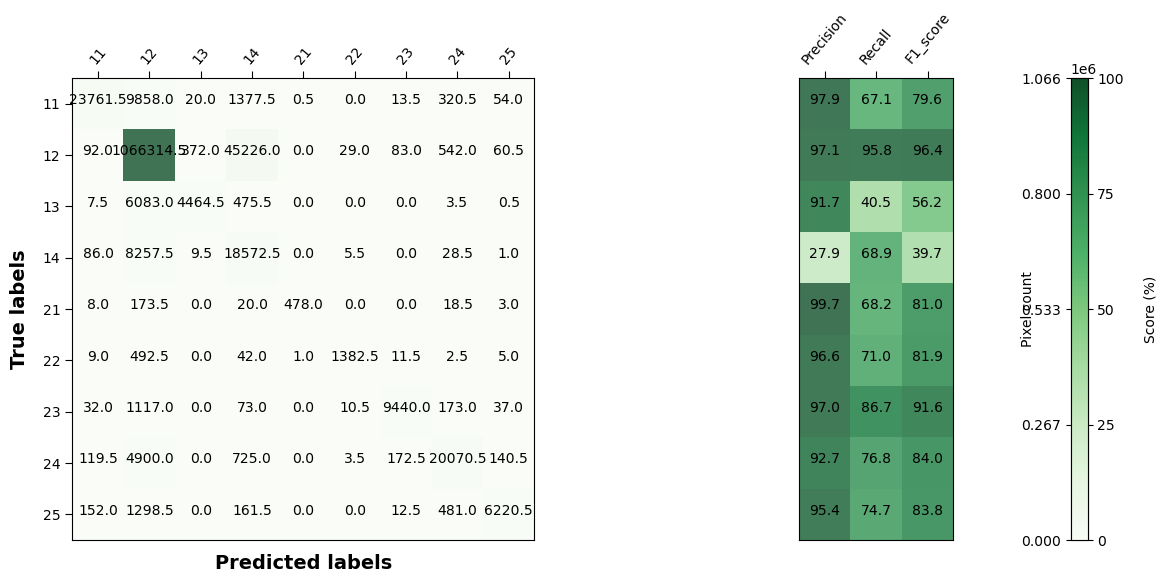

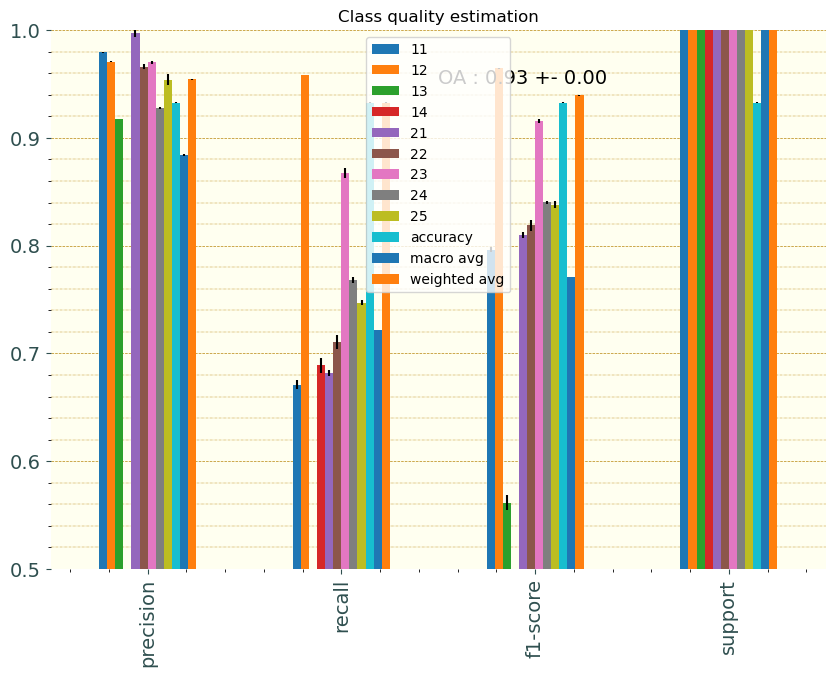

In [12]:
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_pred))

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)

In [ ]:
# Charger l'image raster et préparer les données pour prédiction
raster = gdal.Open(raster_path)
cols, rows, bands = raster.RasterXSize, raster.RasterYSize, raster.RasterCount
geo_transform, projection = raster.GetGeoTransform(), raster.GetProjection()

# Récupérer la valeur NoData du raster source
band = raster.GetRasterBand(1)

# Lire les bandes en tant que tableau float32
raster_array = raster.ReadAsArray().astype(np.float32)

# Identifier les pixels NoData (présents dans au moins une bande)
nodata_mask = np.isnan(raster_array) | (raster_array == nodata_value)
nodata_mask = np.any(nodata_mask, axis=0)  # Combine toutes les bandes

# Restructurer pour la prédiction (pixels, nb_bandes)
data_for_prediction = raster_array.reshape(bands, -1).T
valid_pixels = ~nodata_mask.flatten()
data_valid = data_for_prediction[valid_pixels]

# Prédiction sur les pixels valides
predicted_valid_classes = rf_classifier.predict(data_valid)

# Reconstruction de l'image classifiée
predicted_classes = np.full(rows * cols, fill_value=0, dtype=np.uint8)  # Remplissage par NoData = 0
predicted_classes[valid_pixels] = predicted_valid_classes
predicted_classes = predicted_classes.reshape(rows, cols)

In [ ]:
# Sauvegarde de la carte classifiée
output_path = '../results/data/classif/carte_essences_echelle_pixel.tif'
driver = gdal.GetDriverByName('GTiff')
output_raster = driver.Create(output_path, cols, rows, 1, gdal.GDT_Byte)  # Forçage en uint8

# Définir les propriétés spatiales
output_raster.SetGeoTransform(geo_transform)
output_raster.SetProjection(projection)

# Ajouter la bande et écrire les données
output_band = output_raster.GetRasterBand(1)
output_band.WriteArray(predicted_classes)
output_band.SetNoDataValue(0)  # Fixation de NoData à 0

# Fermeture propre du fichier
output_band.FlushCache()
output_band = None
output_raster = None

print(f"Carte des essences enregistrée sous : {output_path}")

In [ ]:
# Suppression des fichiers intermédiaires
os.remove(raster_temp_code_pixel)
os.remove(raster_temp_ids)
for ext in ['.shp', '.shx', '.dbf', '.prj', '.cpg']:
    shp_file = shp_output.replace('.shp', ext)
    if os.path.exists(shp_file):
        os.remove(shp_file)
print("Fichiers intermédiaires supprimés.")

Fichiers intermédiaires supprimés.
